In [141]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import GridSearchCV


data = pd.read_csv('..\\Fermi-LAT Data\\fl_numericalonly_nopositional_withclasses.csv',index_col=0)

'''
In 'data' all unknown BCUs are assigned 0. 
All BLLs are assigned 1 and all FSRQs are assigned 2.
Radio Galaxies = 3 and Other = 4
'''

mask1 = data['CLASS1'] == 4
mask2 = data['CLASS1'] == 0
mask3 = data['CLASS1'] == 3
data = data[~mask1]
data = data[~mask2]
data = data[~mask3]

''' JOINING BLLs AND FSRQs INTO A SINGLE CATEGORY '''

#data = data.replace(2,1)

data = data.dropna()
data = data.reset_index()

print(len(data['CLASS1']))
data_test = data[~(data['CLASS1'] == 1)]
print(len(data_test['CLASS1']))

1383
470


C:\Users\ioanp\AppData\Local\Temp\ipykernel_14508\718425423.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~mask2]
C:\Users\ioanp\AppData\Local\Temp\ipykernel_14508\718425423.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~mask3]


We will split the dataset (obtained from sklearn load_digits) into a training and test set using the code below 

In [142]:
from sklearn.model_selection import GridSearchCV

X = data.loc[:, data.columns != 'CLASS1']
Y = data['CLASS1']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=4) 
# test_size set the proportion of data to use as test data. The rest of the data will be used as training data

'''HIGHLY RECOMMENDED TO SCALE TRAINING DATA '''

scaler = StandardScaler()  
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)  

hl_list = []
for i in range(12,14):
    hl_list.append((int(i),int(2)))


NN = MLPClassifier(random_state=1, max_iter=1000) # creates the neural network classifier

parameter_space = {
        'hidden_layer_sizes':hl_list,
        'activation':['tanh','relu'],
        'solver':['sgd','adam'],
        'alpha':[0.0001,0.001,0.00001],
        'learning_rate':['constant','invscaling','adaptive']
}

clf = GridSearchCV(NN, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)

# Best paramete set
#print('Best parameters found:\n', clf.best_params_)
'''
# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
'''    
#NN.fit(x_train, y_train)

'\n# All results\nmeans = clf.cv_results_[\'mean_test_score\']\nstds = clf.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, clf.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))\n'

In [143]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (13, 2), 'learning_rate': 'constant', 'solver': 'sgd'}


In [144]:
NN = MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes=(13, 2), learning_rate='constant', solver='sgd', random_state=1, max_iter=1000)
NN.fit(x_train, y_train)


MLPClassifier(hidden_layer_sizes=(13, 2), max_iter=1000, random_state=1,
              solver='sgd')

Now testing the model:

In [145]:
y_pred = NN.predict(x_test)
y_proba = NN.predict_proba(x_test)

accuracy = accuracy_score(y_test, y_pred)*100
confusion = confusion_matrix(y_test, y_pred)
print(accuracy)
(confusion)
#print(y_pred)

91.33574007220217


array([[170,   7],
       [ 17,  83]], dtype=int64)

0          (0.958, 1.0]
1        (0.667, 0.708]
2      (-0.001, 0.0417]
3      (-0.001, 0.0417]
4      (-0.001, 0.0417]
             ...       
272    (-0.001, 0.0417]
273    (-0.001, 0.0417]
274    (-0.001, 0.0417]
275     (0.0833, 0.125]
276        (0.958, 1.0]
Name: p_2, Length: 277, dtype: category
Categories (24, interval[float64, right]): [(-0.001, 0.0417] < (0.0417, 0.0833] < (0.0833, 0.125] < (0.125, 0.167] ... (0.833, 0.875] < (0.875, 0.917] < (0.917, 0.958] < (0.958, 1.0]]


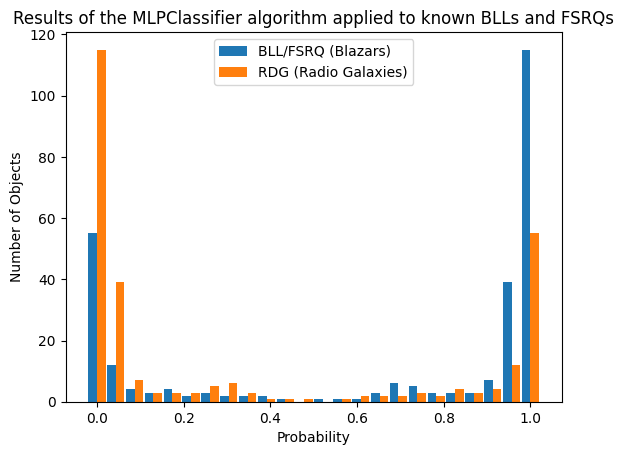

In [152]:
import matplotlib.pyplot as plt
#print(y_proba)
probs = pd.DataFrame(y_proba,columns=('p_1','p_2'))
bin_probs_1 = pd.cut(probs['p_1'],np.linspace(0,1,25),include_lowest=True)
bin_probs_2 = pd.cut(probs['p_2'],np.linspace(0,1,25),include_lowest=True)

print(bin_probs_2)

fig, ax = plt.subplots()
x_axis = np.linspace(0,1,len(bin_probs_1.value_counts()))

ax.bar(x_axis-0.01,bin_probs_1.value_counts(sort=False), width=0.02,label='BLL/FSRQ (Blazars)')
ax.bar(x_axis+0.01,bin_probs_2.value_counts(sort=False),width=0.02,label='RDG (Radio Galaxies)')
ax.legend()
ax.set_xlabel('Probability')
ax.set_ylabel('Number of Objects')
ax.set_title('Results of the MLPClassifier algorithm applied to known BLLs and FSRQs')

plt.show()